# Metrics Analysis: Coverage e Mutation Testing

Questo notebook analizza le metriche di **code coverage** e **mutation score** per ogni agente (single_agent, multi_agent_collaborative, multi_agent_competitive).

In [19]:
import sys
import os
import json  
from pathlib import Path
from importlib import reload
import pandas as pd

# ... rest of the cell ...

# Aggiungi il path del progetto
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import e reload delle funzioni di evaluation (per caricare le ultime modifiche)
import src.evaluation.run_coverage as run_coverage_module
import src.evaluation.run_mutation as run_mutation_module

reload(run_coverage_module)
reload(run_mutation_module)

from src.evaluation.run_coverage import run_coverage, get_coverage_summary
from src.evaluation.run_mutation import run_mutation_testing, get_mutation_summary

print(f"Project root: {PROJECT_ROOT}")
print("Moduli ricaricati correttamente!")

Project root: c:\Users\marco\Desktop\LLM-Agents-for-Collaborative-Test-Case
Moduli ricaricati correttamente!


## Configurazione Paths

Definiamo i path delle cartelle di input (codice sorgente) e output (test generati).

In [20]:
# Paths configuration
INPUT_CODE_DIR = PROJECT_ROOT / "data" / "input_code"
OUTPUT_TESTS_DIR = PROJECT_ROOT / "data" / "output_tests"
RESULTS_DIR = PROJECT_ROOT / "results"


# Mapping tra nome del file test e il modulo sorgente corrispondente
def get_source_module(test_file: Path) -> str:
    """Estrae il nome del modulo sorgente dal nome del file test.
    Ritorna il modulo Python (es. 'data.input_code.library') per pytest-cov.
    """
    # test_library.py -> library
    test_name = test_file.stem  # test_library
    source_name = test_name.replace("test_", "")  # library
    # Ritorna il modulo Python, non il path del file
    return f"data.input_code.{source_name}"


def get_source_file_path(test_file: Path) -> str:
    """Ritorna il path del file sorgente per mutmut."""
    test_name = test_file.stem  # test_library
    source_name = test_name.replace("test_", "") + ".py"  # library.py
    return str(INPUT_CODE_DIR / source_name)


# Lista degli agenti (sottocartelle)
AGENTS = [d.name for d in OUTPUT_TESTS_DIR.iterdir() if d.is_dir()]
print(f"Agenti trovati: {AGENTS}")

Agenti trovati: ['collaborative_strong', 'collaborative_strong_generator', 'collaborative_strong_planner', 'collaborative_weak', 'competitive_dumb_planner_smart_workers', 'competitive_smart_planner_dumb_workers']


## Funzione di Analisi

Funzione principale che esegue coverage e mutation testing per tutti i test di un agente.

In [21]:
def get_file_tokens(agent_name: str, source_file_name: str) -> int:
    """Reads metrics.json to find token usage for a specific file."""
    json_path = RESULTS_DIR / agent_name / "metrics.json"
    if not json_path.exists():
        return 0
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # Search for the specific file entry
        for res in data.get("results", []):
            if res.get("file") == source_file_name:
                # Return total_tokens if available (0 if error/missing)
                return res.get("metrics", {}).get("total_tokens", 0)
    except Exception as e:
        print(f"    [Warning] Could not read tokens for {agent_name}: {e}")
    
    return 0

def analyze_agent(agent_name: str, run_mutation: bool = True) -> dict:
    """
    Analizza tutti i test di un agente, eseguendo coverage e mutation testing.
    Include anche il conteggio dei token usati.
    """
    agent_dir = OUTPUT_TESTS_DIR / agent_name
    test_files = list(agent_dir.glob("test_*.py"))

    results = []

    for test_file in test_files:
        source_module = get_source_module(test_file)
        source_file_path = get_source_file_path(test_file)
        source_name = test_file.stem.replace("test_", "")
        source_filename_py = f"{source_name}.py" # e.g. bank_account.py

        print(f"\n{'='*60}")
        print(f"Analyzing: {agent_name} / {test_file.name}")
        print(f"Source: {source_name}.py")
        print(f"{'='*60}")

        # --- Retrieve Tokens ---
        tokens = get_file_tokens(agent_name, source_filename_py)

        result = {
            "agent": agent_name,
            "test_file": test_file.name,
            "source_file": source_filename_py,
            "tokens": tokens,  # <--- Add tokens here
            "coverage_percent": 0,
            "passed_tests": 0,
            "failed_tests": 0,
            "mutation_score": 0.0,
            "mutants_killed": 0,
            "mutants_survived": 0,
            "coverage_success": False,
            "mutation_success": False,
        }
        
        print(f"    Tokens Used: {tokens}")

        # Run Coverage
        print("\n[1/2] Running Coverage...")
        try:
            cov_result = run_coverage(
                source_module=source_module,
                test_file=str(test_file),
                cwd=str(PROJECT_ROOT),
            )
            result["coverage_percent"] = cov_result["coverage_percent"]
            result["passed_tests"] = cov_result["passed_tests"]
            result["failed_tests"] = cov_result["failed_tests"]
            result["coverage_success"] = cov_result["success"]
            print(f"    Coverage: {cov_result['coverage_percent']}%")
            print(
                f"    Tests: {cov_result['passed_tests']} passed, {cov_result['failed_tests']} failed"
            )
        except Exception as e:
            print(f"    Coverage ERROR: {e}")

        # Run Mutation Testing
        if run_mutation:
            print("\n[2/2] Running Mutation Testing (this may take a while)...")
            try:
                mut_result = run_mutation_testing(
                    source_file=source_file_path,
                    test_file=str(test_file),
                    cwd=str(PROJECT_ROOT),
                    timeout=600,
                )
                result["mutation_score"] = mut_result["mutation_score"]
                result["mutants_killed"] = mut_result["killed"]
                result["mutants_survived"] = mut_result["survived"]
                result["mutation_success"] = mut_result["success"]
                print(f"    Mutation Score: {mut_result['mutation_score']}%")
                print(
                    f"    Killed: {mut_result['killed']}, Survived: {mut_result['survived']}"
                )
            except Exception as e:
                print(f"    Mutation ERROR: {e}")
        else:
            print("\n[2/2] Mutation Testing skipped")

        results.append(result)

    return results

## Esecuzione Analisi

Eseguiamo l'analisi per tutti gli agenti. 

**Nota:** Il mutation testing può richiedere diversi minuti per file. Imposta `RUN_MUTATION = False` per eseguire solo la coverage.

In [22]:
# Configurazione
RUN_MUTATION = True  # Imposta False per saltare mutation testing (più veloce)

# Raccogliamo tutti i risultati
all_results = []

for agent in AGENTS:
    print(f"\n{'#'*60}")
    print(f"# AGENT: {agent.upper()}")
    print(f"{'#'*60}")

    agent_results = analyze_agent(agent, run_mutation=RUN_MUTATION)
    all_results.extend(agent_results)

print("\n\n" + "=" * 60)
print("ANALISI COMPLETATA!")
print("=" * 60)


############################################################
# AGENT: COLLABORATIVE_STRONG
############################################################

Analyzing: collaborative_strong / test_bank_account.py
Source: bank_account.py
    Tokens Used: 5355

[1/2] Running Coverage...
    Coverage: 100%
    Tests: 15 passed, 0 failed

[2/2] Running Mutation Testing (this may take a while)...
    Mutation Score: 66.67%
    Killed: 18, Survived: 9

Analyzing: collaborative_strong / test_hotel_reservation.py
Source: hotel_reservation.py
    Tokens Used: 0

[1/2] Running Coverage...
    Coverage: 0%
    Tests: 0 passed, 0 failed

[2/2] Running Mutation Testing (this may take a while)...
    Mutation Score: 0.0%
    Killed: 0, Survived: 0

Analyzing: collaborative_strong / test_library.py
Source: library.py
    Tokens Used: 7808

[1/2] Running Coverage...
    Coverage: 100%
    Tests: 15 passed, 0 failed

[2/2] Running Mutation Testing (this may take a while)...
    Mutation Score: 73.68%
    K

## Risultati Dettagliati

Visualizziamo tutti i risultati in un DataFrame.

In [23]:
# Creiamo DataFrame con tutti i risultati
df_results = pd.DataFrame(all_results)

# Selezioniamo le colonne da visualizzare
display_cols = [
    "agent",
    "source_file",
    "tokens",  
    "coverage_percent",
    "passed_tests",
    "failed_tests",
    "mutation_score",
    "mutants_killed",
    "mutants_survived",
]

df_results[display_cols]

,agent,source_file,tokens,coverage_percent,passed_tests,failed_tests,mutation_score,mutants_killed,mutants_survived
0,collaborative_strong,bank_account.py,5355,100,15,0,66.67,18,9
1,collaborative_strong,hotel_reservation.py,0,0,0,0,0.00,0,0
2,collaborative_strong,library.py,7808,100,15,0,73.68,28,10
3,collaborative_strong_generator,bank_account.py,5594,100,15,0,66.67,18,9
4,collaborative_strong_generator,hotel_reservation.py,19842,100,22,0,70.18,40,17
5,collaborative_strong_generator,library.py,21649,100,15,0,90.62,29,3
6,collaborative_strong_planner,bank_account.py,6827,100,14,0,52.38,11,10
7,collaborative_strong_planner,hotel_reservation.py,15462,100,17,0,61.40,35,22
8,collaborative_strong_planner,library.py,9177,100,17,0,60.53,23,15
9,collaborative_weak,bank_account.py,13178,100,35,0,66.67,18,9


## Riepilogo per Agente

Calcoliamo la **coverage media** e il **mutation score medio** per ogni agente.

In [24]:
# Calcolo medie per agente
df_summary = (
    df_results.groupby("agent")
    .agg(
        {
            "tokens": "sum",  
            "coverage_percent": ["mean", "std", "min", "max"],
            "mutation_score": ["mean", "std", "min", "max"],
            "passed_tests": "sum",
            "failed_tests": "sum",
            "mutants_killed": "sum",
            "mutants_survived": "sum",
        }
    )
    .round(2)
)

# Flatten column names
df_summary.columns = ["_".join(col).strip() for col in df_summary.columns.values]

# Rename tokens_sum for clarity if needed
df_summary.rename(columns={"tokens_sum": "total_tokens"}, inplace=True)

print("=" * 70)
print("RIEPILOGO METRICHE PER AGENTE")
print("=" * 70)
df_summary

RIEPILOGO METRICHE PER AGENTE


,total_tokens,coverage_percent_mean,coverage_percent_std,coverage_percent_min,coverage_percent_max,mutation_score_mean,mutation_score_std,mutation_score_min,mutation_score_max,passed_tests_sum,failed_tests_sum,mutants_killed_sum,mutants_survived_sum
agent,,,,,,,,,,,,,
collaborative_strong,13163,66.67,57.74,0,100,46.78,40.67,0.00,73.68,30,0,46,19
collaborative_strong_generator,47085,100.00,0.00,100,100,75.82,12.93,66.67,90.62,52,0,87,29
collaborative_strong_planner,31466,100.00,0.00,100,100,58.10,4.98,52.38,61.40,48,0,69,47
collaborative_weak,63281,100.00,0.00,100,100,67.00,6.65,60.53,73.81,85,0,72,35
competitive_dumb_planner_smart_workers,0,50.00,70.71,0,100,33.34,47.14,0.00,66.67,27,0,18,9
competitive_smart_planner_dumb_workers,147662,100.00,0.00,100,100,68.34,29.22,35.71,92.11,57,0,84,25


## Tabella Riepilogativa Finale

Visualizzazione semplificata delle metriche principali per agente.

In [27]:
# Tabella semplificata con medie
final_summary = (
    df_results.groupby("agent")
    .agg(
        {
            "tokens": "sum",
            "coverage_percent": "mean",
            "mutation_score": "mean",
            "passed_tests": "sum",
            "failed_tests": "sum",
        }
    )
    .round(2)
)

final_summary.columns = [
    "Total Tokens",
    "Coverage Media (%)",
    "Mutation Score Medio (%)",
    "Test Passati (totale)",
    "Test Falliti (totale)",
]


print("\n" + "=" * 70)
print("  RISULTATI FINALI - CONFRONTO AGENTI")
print("=" * 70 + "\n")

for agent in final_summary.index:
    row = final_summary.loc[agent]
    print(f"📊 {agent.upper()}")
    print(f"   ├─ Coverage Media:      {row['Coverage Media (%)']}%")
    print(f"   ├─ Mutation Score:      {row['Mutation Score Medio (%)']}%")
    print(
        f"   └─ Test: {int(row['Test Passati (totale)'])} passati, {int(row['Test Falliti (totale)'])} falliti"
    )
    print()

print("=" * 70)

# Display DataFrame
final_summary


  RISULTATI FINALI - CONFRONTO AGENTI

📊 COLLABORATIVE_STRONG
   ├─ Coverage Media:      66.67%
   ├─ Mutation Score:      46.78%
   └─ Test: 30 passati, 0 falliti

📊 COLLABORATIVE_STRONG_GENERATOR
   ├─ Coverage Media:      100.0%
   ├─ Mutation Score:      75.82%
   └─ Test: 52 passati, 0 falliti

📊 COLLABORATIVE_STRONG_PLANNER
   ├─ Coverage Media:      100.0%
   ├─ Mutation Score:      58.1%
   └─ Test: 48 passati, 0 falliti

📊 COLLABORATIVE_WEAK
   ├─ Coverage Media:      100.0%
   ├─ Mutation Score:      67.0%
   └─ Test: 85 passati, 0 falliti

📊 COMPETITIVE_DUMB_PLANNER_SMART_WORKERS
   ├─ Coverage Media:      50.0%
   ├─ Mutation Score:      33.34%
   └─ Test: 27 passati, 0 falliti

📊 COMPETITIVE_SMART_PLANNER_DUMB_WORKERS
   ├─ Coverage Media:      100.0%
   ├─ Mutation Score:      68.34%
   └─ Test: 57 passati, 0 falliti



,Total Tokens,Coverage Media (%),Mutation Score Medio (%),Test Passati (totale),Test Falliti (totale)
agent,,,,,
collaborative_strong,13163,66.67,46.78,30,0
collaborative_strong_generator,47085,100.00,75.82,52,0
collaborative_strong_planner,31466,100.00,58.10,48,0
collaborative_weak,63281,100.00,67.00,85,0
competitive_dumb_planner_smart_workers,0,50.00,33.34,27,0
competitive_smart_planner_dumb_workers,147662,100.00,68.34,57,0


## Visualizzazione Grafica

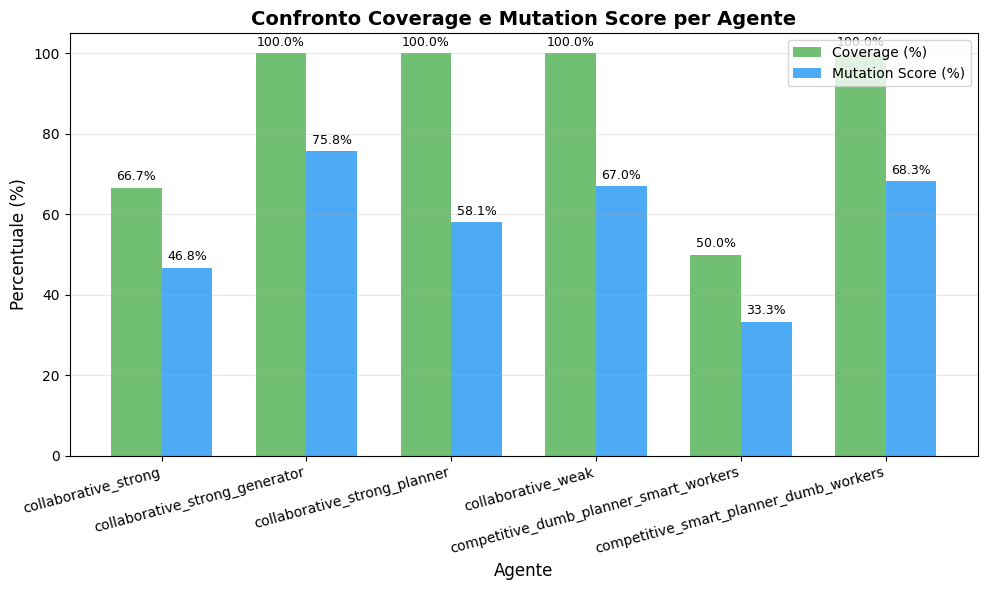

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Data
# Aggregate: mean for percentages, SUM for tokens (to see total cost/usage)
plot_data = (
    df_results.groupby("agent")
    .agg({
        "coverage_percent": "mean", 
        "mutation_score": "mean",
        "tokens": "sum"
    })
    .reset_index()
)

# 2. Create Plot with Dual Axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# X-axis configuration
x = np.arange(len(plot_data))
width = 0.25  # Thinner bars to fit 3 metrics

# --- Left Axis (Percentages) ---
ax1.set_xlabel("Agent", fontsize=12)
ax1.set_ylabel("Percentage (%)", fontsize=12, color="#333333")
ax1.set_title("Comparison: Coverage, Mutation Score & Token Usage", fontsize=14, fontweight="bold")
ax1.set_ylim(0, 115)  # Slightly higher to fit labels

# Bars for percentages
bar1 = ax1.bar(x - width, plot_data["coverage_percent"], width, label="Coverage (%)", color="#4CAF50", alpha=0.9)
bar2 = ax1.bar(x, plot_data["mutation_score"], width, label="Mutation Score (%)", color="#2196F3", alpha=0.9)

# --- Right Axis (Tokens) ---
ax2 = ax1.twinx()  # Share x-axis
ax2.set_ylabel("Total Tokens Used", fontsize=12, color="#FF9800")
# Adjust limit to make room for labels, start from 0
max_tokens = plot_data["tokens"].max()
ax2.set_ylim(0, max_tokens * 1.2) 

# Bar for tokens
bar3 = ax2.bar(x + width, plot_data["tokens"], width, label="Total Tokens", color="#FF9800", alpha=0.7)
ax2.tick_params(axis='y', labelcolor="#FF9800")

# --- Formatting ---
ax1.set_xticks(x)
ax1.set_xticklabels(plot_data["agent"], rotation=15, ha="right")

# Combined Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=True, shadow=True)

# Function to add value labels
def add_labels(bars, ax, is_int=False, color="black"):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            label = f'{int(height)}' if is_int else f'{height:.1f}%'
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')

add_labels(bar1, ax1)
add_labels(bar2, ax1)
add_labels(bar3, ax2, is_int=True, color="#D35400") # Darker orange for visibility

plt.tight_layout()
plt.grid(axis="y", alpha=0.3)

# Save the plot
output_img = PROJECT_ROOT / "data" / "metrics_comparison.png"
plt.savefig(output_img, dpi=300, bbox_inches="tight")
print(f"Graph saved to: {output_img}")

plt.show()

## Export Risultati

Salviamo i risultati in un file CSV per analisi successive.

In [ ]:
# Salva risultati dettagliati
output_path = PROJECT_ROOT / "data" / "metrics_results.csv"
df_results.to_csv(output_path, index=False)
print(f"Risultati salvati in: {output_path}")

# Salva summary
summary_path = PROJECT_ROOT / "data" / "metrics_summary.csv"
final_summary.to_csv(summary_path)
print(f"Summary salvato in: {summary_path}")